Notebook derived from: https://colab.research.google.com/drive/1uJOmAg6RjlOIJj6SWN9sYRamBdHAuyaS#scrollTo=QfS2vhlp2TKo

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
import cv2

import xplique
from xplique.plots import plot_attributions

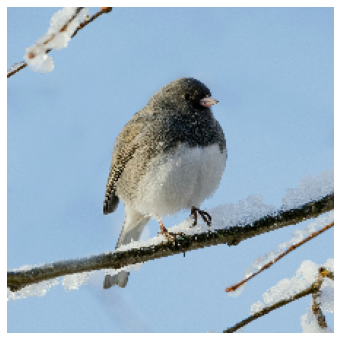

In [2]:
# Image downloaded from https://unsplash.com/photos/a-small-bird-perched-on-a-tree-branch-covered-in-snow-VmhukusE8_Y
img_path = 'junco.jpg'

def central_crop_and_resize(img, size=224):
    """
    Given a numpy array, extracts the largest possible square and resizes it to
    the requested size
    """
    h, w, _ = img.shape

    min_side = min(h, w)
    max_side_center = max(h, w) // 2.0

    min_cut = int(max_side_center-min_side//2)
    max_cut = int(max_side_center+min_side//2)

    img = img[:, min_cut:max_cut] if w > h else img[min_cut:max_cut]
    img = tf.image.resize(img, (size, size))

    return img

X = central_crop_and_resize(cv2.imread(img_path)[..., ::-1])[None, :, :, :]
Y = tf.keras.utils.to_categorical(13, 1000)[None, :] # junco, snowbird (13th ImageNet class)

plt.rcParams["figure.figsize"] = [15, 6]
plt.imshow(X[0]/255.0)
plt.axis('off')
plt.show()

In [3]:
import tensorflow.keras.applications as app

# load the model and preprocess the inputs (adapt the input range)
model, preprocess = app.ResNet50V2(), app.resnet_v2.preprocess_input
model.layers[-1].activation = tf.keras.activations.linear

# as we have only 1 image, expand the batch dimension
X_preprocessed = preprocess(np.array(X, copy=True))
print('Is prediction correct ?', np.argmax(model(X_preprocessed)) == np.argmax(Y))

Is prediction correct ? True


In [4]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop, DeconvNet,
                                  Lime, KernelShap)

batch_size = 1
explainers = [Saliency(model),
            GradientInput(model),
            GuidedBackprop(model),
            DeconvNet(model),
            IntegratedGradients(model, steps=80, batch_size=batch_size),
            SmoothGrad(model, nb_samples=80, batch_size=batch_size),
            GradCAM(model),
            Occlusion(model, patch_size=10, patch_stride=10),
            VarGrad(model, nb_samples=80, batch_size=batch_size),
            SquareGrad(model, nb_samples=80, batch_size=batch_size),
            Rise(model, nb_samples=80, batch_size=batch_size),
            Lime(model, nb_samples = 80),
            KernelShap(model, nb_samples = 80)]

In [6]:
# prepare a plotting function to show the explanation
def show_explanation(explanation, alpha = .5, percentile = 0.1):
    explanation = np.abs(explanation)

    if explanation.shape[-1] == 3:
        explanation = np.mean(explanation, -1)

    if percentile is not None:
        clip_min = np.percentile(explanation, percentile)
        clip_max = np.percentile(explanation, 100 - percentile)
        explanation = np.clip(explanation, clip_min, clip_max)

    explanation = explanation - explanation.min()
    explanation = explanation / (explanation.max() + 1e-6)

    plt.imshow(explanation, cmap='jet', alpha=alpha)
    plt.axis('off')

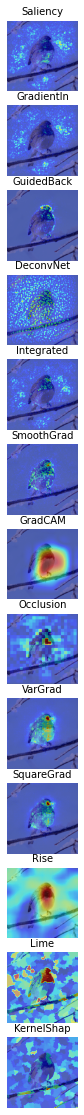

In [7]:
plt.rcParams["figure.figsize"] = [20, 20]

for explainer_id, explainer in enumerate(explainers):
    explainer_name = explainer.__class__.__name__
    # compute the explanation for the given explainer (all the explainer share the same api)
    explanation = explainer(X_preprocessed, Y)[0]

    plt.subplot(len(explainers), 1, explainer_id+1)
    plt.title(explainer_name[:10], fontsize=10)

    plt.imshow(X[0]/255.0)
    show_explanation(explanation)

plt.show()

### Analytical vs Empirical (multiple methods, multiple variances)

In [ ]:
stds = [0.1, 0.2, 0.3, 0.4, 0.5] # std. deviations
num_perturbations = 10 # for empirical cov.
dx = 1e-3 # differential for ana. cov.
h = w = X_preprocessed.shape[1] # (1, 244, 244, 3)
n = np.product(np.shape(X_preprocessed)[:-1]) # for simplicity, treat RGB channels as one point/step
m = np.product(np.shape(explanation)) # (244, 244, 1)

# Store results for plotting
results, cov_mats = {}, {}

for explainer in explainers[:1]:
    name = explainer.__class__.__name__
    print('\n' + name)
    results[name]  = {'analytical': [], 'empirical': []}
    cov_mats[name] = {'analytical': [], 'empirical': []}
    
    # Precompute Jacobian (stays fixed for every std)
    derivative_e_x = np.zeros((m, n))
    # For every pixel perturbation, we get a new column in the Jacobian
    for i in range(10):
        if i%10==0: print(i)
        for j in range(10):
            # Perturb pixel (i, j)
            perturbed_image_pos, perturbed_image_neg = np.copy(X_preprocessed), np.copy(X_preprocessed)
            perturbed_image_pos[0, i, j, :] += dx
            perturbed_image_neg[0, i, j, :] -= dx
            perturbed_image_pos = np.clip(perturbed_image_pos, 0, 1)  # Keep within valid range
            perturbed_image_neg = np.clip(perturbed_image_neg, 0, 1)

            # Compute explanation for perturbed image
            perturbed_explanation_pos = explainer(perturbed_image_pos, Y)[0]
            perturbed_explanation_neg = explainer(perturbed_image_neg, Y)[0]

            # Compute finite difference gradient
            gauss_perturbed_exp_pos = cv2.GaussianBlur(perturbed_explanation_pos.numpy(), (3,3), 6)
            gauss_perturbed_exp_neg = cv2.GaussianBlur(perturbed_explanation_neg.numpy(), (3,3), 6)

            # Normalize the explanations to [0, 1]
            normalized_perturbed_exp_pos = (gauss_perturbed_exp_pos - gauss_perturbed_exp_pos.min()) / (gauss_perturbed_exp_pos.max() - gauss_perturbed_exp_pos.min())
            normalized_perturbed_exp_neg = (gauss_perturbed_exp_neg - gauss_perturbed_exp_neg.min()) / (gauss_perturbed_exp_neg.max() - gauss_perturbed_exp_neg.min())

            # Fill out the corresponding column in the jacobian
            derivative_2d = (normalized_perturbed_exp_pos - normalized_perturbed_exp_neg) / (2*dx)
            flat_ind = i * w + j
            derivative_e_x[:, flat_ind] = derivative_2d.reshape(m, )

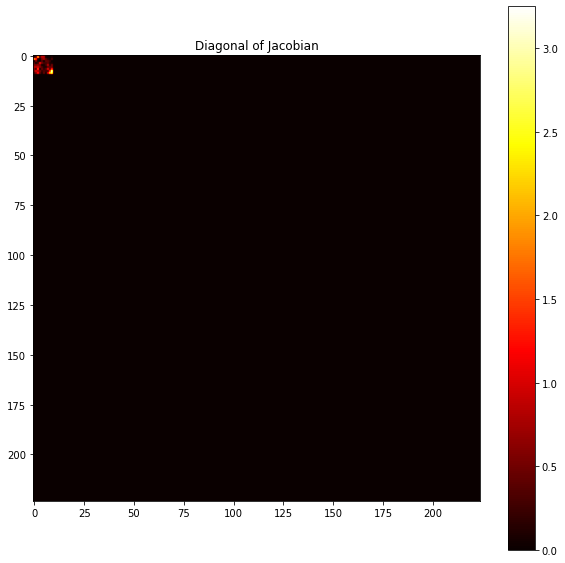

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(np.diag(derivative_e_x).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Jacobian")
plt.colorbar()
plt.show()